In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
ed = tfp.edward2
import sys
sys.path.append("../")
from future_features import tape
import numpy as np
from plot_utils import plot_source_distributions

/home/folzd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from testsuite import MAP_model, neg_log_lik

/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/im

In [3]:
from tfpmodels import independentFactorAnalysis, centeredIndependentFactorAnalysis
from tfpmodels import centeredIndependentFactorAnalysisTest2 as centeredIndependentFactorAnalysisTest
from mapper import Mapper

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import FastICA, PCA

In [5]:
sess = tf.InteractiveSession()

In [6]:
n_components_in_mixture = 10
n_sources = 2
n_features = 2
n_observations = 5000

In [7]:
ifa = Mapper(centeredIndependentFactorAnalysis, 'ifa2', ['data'], n_observations=n_observations, n_components_in_mixture=n_components_in_mixture, n_features=n_features, n_sources=n_sources, mixture_component_var_concentration=.1, mixture_component_var_rate=1.,data_var_concentration=.1,data_var_rate=10.)

In [8]:
ifa.unconstrained_variables

{'mixture_component_var': <tf.Variable 'ifa2/mixture_component_var:0' shape=(2, 10) dtype=float32_ref>,
 'mixture_weights': <tf.Variable 'ifa2/mixture_weights:0' shape=(2, 9) dtype=float32_ref>,
 'sources': <tf.Variable 'ifa2/sources:0' shape=(5000, 2) dtype=float32_ref>,
 'factor_loadings': <tf.Variable 'ifa2/factor_loadings:0' shape=(2, 2) dtype=float32_ref>,
 'data_var': <tf.Variable 'ifa2/data_var:0' shape=(1, 2) dtype=float32_ref>}

In [9]:
generated = sess.run(ifa.tape)

In [10]:
fica = FastICA(n_components=n_sources).fit(generated['data']).mixing_.T
loss, opt = ifa.map_optimizer(data=generated['data'])
sess.run(tf.global_variables_initializer())

# Initialize in true parameters, as a sanity check
true_parameters = dict(generated)
true_parameters.pop('data')
sess.run(ifa.assigner(**true_parameters))

# FastICA, large SNR initialization
#sess.run(tf.assign(ifa.unconstrained_variables['factor_loadings'], fica,name='initialize_directions'))
#sess.run(tf.assign(ifa.unconstrained_variables['mixture_component_var'], 10*generated['data'].var()*np.random.rand(n_sources,n_components_in_mixture),name='initialize_signal_variance'))
#sess.run(tf.assign(ifa.unconstrained_variables['data_var'], 1e-3*np.ones(ifa.unconstrained_variables['data_var'].shape),name='initialize_noise_variance'))

initialized_parameters = sess.run(ifa.variables)
#initialized_parameters.pop('sources')
train_nll_init = neg_log_lik(initialized_parameters,centeredIndependentFactorAnalysisTest,generated['data'])
#sess.run(tf.assign(ifa.unconstrained_variables['sources'], 2*np.ones(ifa.variable_shapes['sources'])))
opt.minimize()

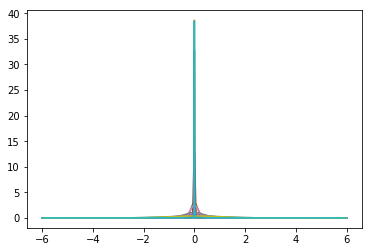

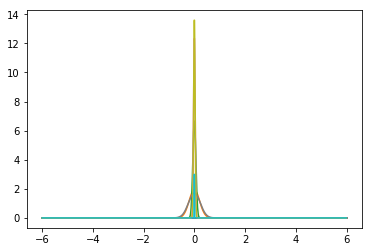

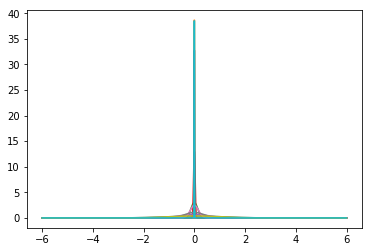

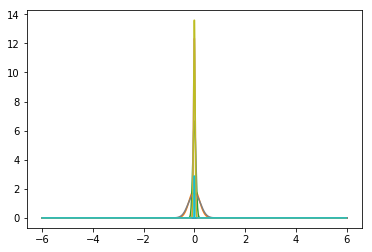

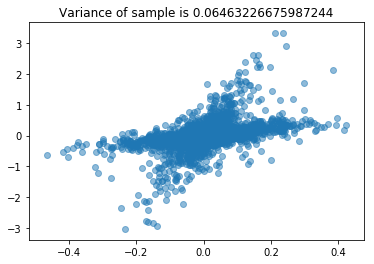

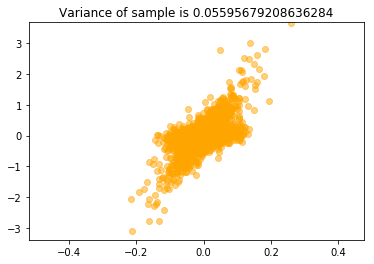

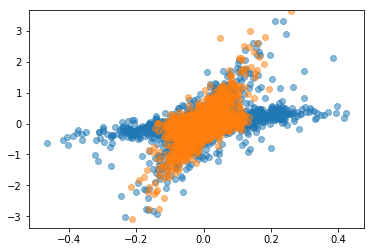

In [11]:
map_estimates = dict(ifa.variables)
map_estimates.pop('sources')

testmodel = centeredIndependentFactorAnalysisTest(n_observations=n_observations, **map_estimates)
#testmodel = centeredIndependentFactorAnalysisTest(n_observations=n_observations, mc_samples=1, **map_estimates)
ppc = sess.run(testmodel.distribution.sample())

plot_source_distributions(generated['mixture_component_var'],sess)
plot_source_distributions(map_estimates['mixture_component_var'],sess)

fig, ax = plt.subplots()
plt.title('Variance of sample is {}'.format(generated['data'].var()))
plt.scatter(*generated['data'].T,alpha=.5)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
plt.show()

fig, ax = plt.subplots()
plt.title('Variance of sample is {}'.format(ppc.var()))
plt.scatter(*ppc.T, alpha=.5,c='orange')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

fig, ax = plt.subplots()
plt.scatter(*generated['data'].T,alpha=.5)
plt.scatter(*ppc.T, alpha=.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

In [12]:
train_nll = neg_log_lik(map_estimates,centeredIndependentFactorAnalysisTest,generated['data'])

In [13]:
sess.run(train_nll_init)

4.5968127

In [14]:
# run train_nll 100 times to estimate variance of the log-likelihood estimate
#train_nlls = []
#for i in range(100):
    #train_nlls.append(sess.run(train_nll_init))
#train_nlls = np.array(train_nlls)
#print(train_nlls)
#print(train_nlls.mean())
#print(train_nlls.std())

In [15]:
generated_vars = generated.copy()
map_estimate_vars = sess.run(map_estimates)

In [16]:
generated_vars.pop('data')
train_nll_true_model = neg_log_lik(generated_vars,centeredIndependentFactorAnalysisTest,generated['data'])

In [17]:
sess.run(train_nll_true_model)

4.3357277

In [18]:
print(generated['mixture_component_var'].mean(1))
print(map_estimate_vars['mixture_component_var'].mean(1))

[0.2717309  0.01017101]
[0.2717309  0.01017101]


In [19]:
print(generated['data_var'])
print(map_estimate_vars['data_var'])

[[0.00055588 0.01330728]]
[[0.00055584 0.01330733]]


In [20]:
fgen = generated['factor_loadings']
fpred = map_estimate_vars['factor_loadings']
fgen = 100*fgen/np.linalg.norm(fgen,axis=1,keepdims=True)
fpred = 100*fpred/np.linalg.norm(fpred,axis=1,keepdims=True)
fica_n = 100*fica/np.linalg.norm(fica, axis=1, keepdims=True)

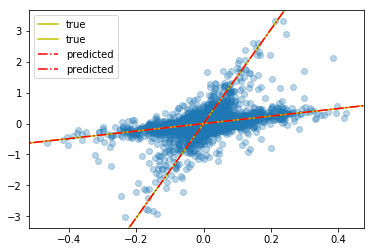

In [21]:
fig, ax = plt.subplots()
ax.scatter(*generated['data'].T,alpha=0.3)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

for fg in fgen:
    plt.plot(fg[0]*np.array([1,-1]),fg[1]*np.array([1,-1]),color='y',label='true')

for fg in fpred:
    plt.plot(fg[0]*np.array([1,-1]),fg[1]*np.array([1,-1]),color='r', linestyle='-.', label='predicted')

#for fg in fica_n:
#    plt.plot(fg[0]*np.array([1,-1]),fg[1]*np.array([1,-1]),color='k',linestyle='--',label='initial')

plt.legend()
ax.set_xlim(xlim)
ax.set_ylim(ylim);

#plt.plot((-1,1),(0,0),'k--')
#plt.plot((0,0),(-1,1),'k--')



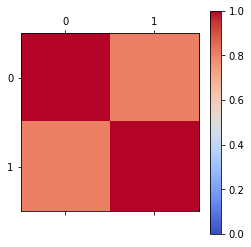

In [22]:
plt.matshow(np.abs(cosine_similarity(generated['factor_loadings'],map_estimate_vars['factor_loadings'])),cmap='coolwarm',vmin=0,vmax=1)
plt.colorbar()

In [23]:
generated_vars

OrderedDict([('mixture_component_var',
              array([[1.1659813e+00, 2.4615458e-05, 1.7408483e-02, 9.1701787e-04,
                      3.1127366e-01, 1.6343702e-05, 2.5949460e-02, 1.3472074e-01,
                      1.0609933e+00, 2.4216019e-05],
                     [1.7959160e-09, 4.2197421e-02, 3.5590464e-03, 2.1793470e-14,
                      3.2559583e-07, 8.8048722e-07, 1.0105681e-03, 5.4112524e-02,
                      8.2499895e-04, 4.3357954e-06]], dtype=float32)),
             ('mixture_weights',
              array([[0.03321487, 0.2054996 , 0.06721867, 0.23240533, 0.06824177,
                      0.12291422, 0.06089533, 0.04940514, 0.02449797, 0.13570699],
                     [0.12439427, 0.23594753, 0.10465835, 0.07267404, 0.00101237,
                      0.18569845, 0.12846395, 0.019781  , 0.06432285, 0.06304722]],
                    dtype=float32)),
             ('sources', array([[ 4.36942372e-03, -1.46399302e-07],
                     [-4.63702856e-03, -

In [24]:
map_estimate_vars

{'mixture_component_var': array([[1.1659813e+00, 2.4556812e-05, 1.7408431e-02, 9.1701408e-04,
         3.1127372e-01, 1.6331540e-05, 2.5949487e-02, 1.3472077e-01,
         1.0609933e+00, 2.4199193e-05],
        [1.7959160e-09, 4.2197391e-02, 3.5590897e-03, 2.1793456e-14,
         3.2559592e-07, 8.8048756e-07, 1.0106224e-03, 5.4112531e-02,
         8.2494557e-04, 4.2915253e-06]], dtype=float32),
 'mixture_weights': array([[0.03321487, 0.20549962, 0.06721867, 0.23240535, 0.06824177,
         0.12291424, 0.06089533, 0.04940514, 0.02449797, 0.13570699],
        [0.12439428, 0.23594753, 0.10465834, 0.07267404, 0.00101237,
         0.18569845, 0.12846397, 0.01978099, 0.06432285, 0.06304722]],
       dtype=float32),
 'factor_loadings': array([[0.10579763, 1.613592  ],
        [0.3415549 , 0.4153909 ]], dtype=float32),
 'data_var': array([[0.00055584, 0.01330733]], dtype=float32)}